In [5]:
import pandas as pd
import seaborn as sns

data = pd.read_csv("./heart.csv", sep=",")

In [6]:
import pandas as pd
import matplotlib as plb
import matplotlib.pyplot as plt
from sklearn import preprocessing
import imblearn
from collections import Counter

def pre(data): 
    to_drop_columns = [ 'exang', 'ca', 'cp', 'slope', 'oldpeak', 'restecg']
    data.drop(to_drop_columns, axis=1, inplace=True)
    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal", "target"]
    
    scaler = preprocessing.MinMaxScaler((0, 1))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data=data, columns=colonne_tenute)
    print(data)

    oversample = imblearn.over_sampling.SMOTE() #usa k-nearest-neighbours
    x_data, y_data = oversample.fit_resample(data.iloc[: , : -1], data["target"])


    return x_data, y_data
        

In [7]:
from sklearn import naive_bayes
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

x_train, y_train = pre(data)
flag = 0

for i in range (0, 50):
    cv = KFold(n_splits=10)
    model = naive_bayes.GaussianNB()
    score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) #errore assoluto per 10 split
    flag = flag + mean(absolute(score))
print(flag/50)
#fa 10 volte il training e stampa la media dell'errore assoluto di ogni validazione


           age  sex  trestbps      chol  fbs   thalach      thal  target
0     0.479167  1.0  0.292453  0.196347  0.0  0.740458  1.000000     0.0
1     0.500000  1.0  0.433962  0.175799  1.0  0.641221  1.000000     0.0
2     0.854167  1.0  0.481132  0.109589  0.0  0.412214  1.000000     0.0
3     0.666667  1.0  0.509434  0.175799  0.0  0.687023  1.000000     0.0
4     0.687500  0.0  0.415094  0.383562  1.0  0.267176  0.666667     0.0
...        ...  ...       ...       ...  ...       ...       ...     ...
1020  0.625000  1.0  0.433962  0.216895  0.0  0.709924  0.666667     1.0
1021  0.645833  1.0  0.292453  0.301370  0.0  0.534351  1.000000     0.0
1022  0.375000  1.0  0.150943  0.340183  0.0  0.358779  0.666667     0.0
1023  0.437500  0.0  0.150943  0.292237  0.0  0.671756  0.666667     1.0
1024  0.520833  1.0  0.245283  0.141553  0.0  0.320611  1.000000     0.0

[1025 rows x 8 columns]
0.23007187780772698


/tmp/ipykernel_19079/1927756533.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_19079/1927756533.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


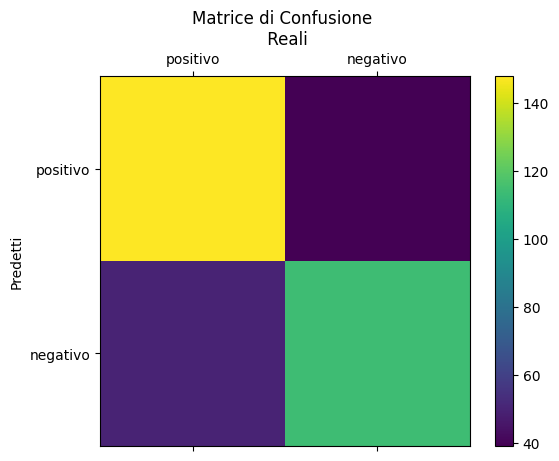

recall =  0.6951219512195121
precision =  0.7450980392156863
accuracy =  0.7464387464387464
f1 =  0.719242902208202


In [8]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from pyJoules.energy_meter import EnergyContext
from pyJoules.device.rapl_device import RaplPackageDomain, RaplDramDomain
from pyJoules.handler.csv_handler import CSVHandler
csv_handler = CSVHandler('bayes_results_training.csv')

model = naive_bayes.GaussianNB()

with EnergyContext(handler=csv_handler, 
                    domains=[RaplPackageDomain(0), 
                            RaplDramDomain(0)]) as ctx:
    ctx.record()
    model.fit(x_train, y_train)

csv_handler.save_data()


csv_handler = CSVHandler('bayes_results_prediction.csv')
with EnergyContext(handler=csv_handler, 
                    domains=[RaplPackageDomain(0), 
                            RaplDramDomain(0)]) as ctx:
    ctx.record()
    prediction = model.predict(x_train[701:])

csv_handler.save_data()




labels = ['positivo', 'negativo']
matrice = confusion_matrix(y_train[701:], prediction)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrice)
plt.title('Matrice di Confusione \n Reali')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('Predetti')
#plt.xlabel('Reali')
plt.show()


recall_value = recall_score(y_train[701:], prediction)
print("recall = ", recall_value)

precision_value = precision_score(y_train[701:], prediction)
print("precision = ", precision_value)

accuracy_value = accuracy_score(y_train[701:], prediction)
print("accuracy = ", accuracy_value)

fmeasure_value = f1_score(y_train[701:], prediction)
print("f1 = ", fmeasure_value)

In [9]:
import flask
from flask import request, jsonify
from flask import Response
import numpy as np
import pandas as pd

app = flask.Flask(__name__)

@app.route('/', methods=['POST'])
def predici():
    query_parameters = request.get_json()
    x_data = pd.DataFrame(query_parameters, index=[0])
    
    age = query_parameters["age"]
    sex = query_parameters["sex"]
    trestbps = query_parameters["trestbps"]
    chol = query_parameters["chol"]
    fbs = query_parameters["fbs"]
    thalach = query_parameters["thalach"]
    thal = query_parameters["thal"]

    v = np.array(x_data)

    scaler = preprocessing.MinMaxScaler((0, 1))
    x_data = scaler.fit_transform(v.reshape(7,1))


    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal"]
    x_data = pd.DataFrame(data=x_data.reshape(1, 7), columns=colonne_tenute)

    print("dopo scaling ", x_data)
    
    #chiama il modello
    csv_handler = CSVHandler('bayes_results_prediction.csv')

    with EnergyContext(handler=csv_handler, 
                    domains=[RaplPackageDomain(0), 
                            RaplDramDomain(0)]) as ctx:
        ctx.record()
        result = model.predict(x_data)

    csv_handler.save_data()


    return str(result)

if __name__ == "__main__":
    app.run(port=8082)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8082
INFO:werkzeug:Press CTRL+C to quit
